Compare this implimentation to the one from the official Torch tutorial:
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.autograd as autograd
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Seed control, for better reproducibility 
# NOTE: this does not gurantee results are always the same
seed = 22
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # work on a single GPU or CPU
    cudnn.benchmark=True
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    Tensor = torch.cuda.FloatTensor
else:
    device = torch.device("cpu")
    cudnn.benchmark=False
    Tensor = torch.FloatTensor

print(device)

EPOCHS = 500


cpu


In [2]:
def imshow(img):
    # custom show in order to display
    # torch tensors as numpy
    npimg = img.numpy() / 2 + 0.5 # from tensor to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

batch_size = 250 # might try to use large batches (we will discuss why later when we talk about BigGAN)
# NOTE: the batch_size should be an integer divisor of the data set size  or torch
# will give you an error regarding batch sizes of "0" when the data loader tries to
# load in the final batch

dataset = dset.CIFAR10(root='data/cifar/', download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))

# frogs are the sixth class in the dataset 
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
frog = 6
frog_index = [i for i, x in enumerate(dataset.targets) if x == 6]
print("number of frog imgs: ", len(frog_index))

frog_set = torch.utils.data.Subset(dataset, frog_index)


dataloader = torch.utils.data.DataLoader(frog_set, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

Files already downloaded and verified
number of frog imgs:  5000


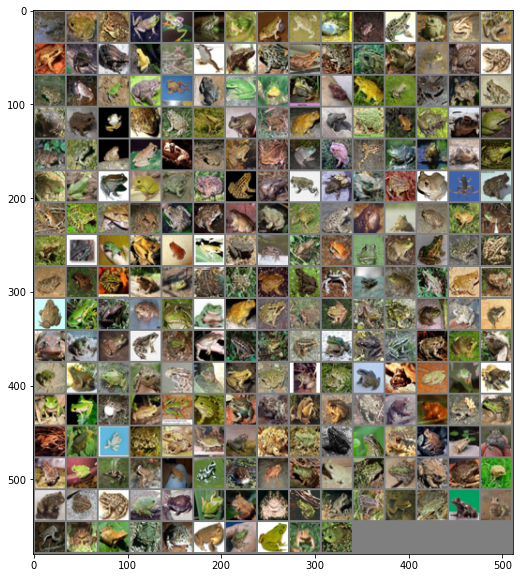

Image shape:  torch.Size([3, 32, 32])


In [3]:
# get some random training images
dataiter = iter(dataloader)
real_image_examples, _ = dataiter.next()

# show images
plt.figure(figsize=(10,10))
imshow(torchvision.utils.make_grid(real_image_examples, nrow=int(np.sqrt(batch_size))))
print("Image shape: ", real_image_examples[0].size())


In [4]:
# create Utils functions for saving and loading 
def save_checkpoint(new_img_list, loaded_ims, g_model, d_model, file_prefix):
    # save off a checkpoint of the current models and images
    
    # convert to numpy images for saving
    ims = np.array([np.transpose(np.hstack((i,real_image_numpy)), (2,1,0)) for i in new_img_list])
    
    # if we have saved images from another run, concatenate and save them here
    if len(loaded_ims)>0:
        ims = np.concatenate((loaded_ims,ims)) # concatenate these images with other runs (if needed)
        
    np.save(f'models/gan_models/{file_prefix}_images.npy',ims)

    # save the state of the models (will need to recreate upon reloading)
    torch.save({'state_dict': g_model.state_dict()}, f'models/gan_models/{file_prefix}_gen.pth')
    torch.save({'state_dict': d_model.state_dict()}, f'models/gan_models/{file_prefix}_dis.pth')
   
def load_checkpoint(file_prefix, gen_func, disc_func):
    # load up checkpoint images from previous runs
    ims = np.load(f'models/gan_models/{file_prefix}_images.npy')

    generator = gen_func() # create generator (no weights)
    discriminator = disc_func() # create disciminator (no weights)

    # now populate the weights from a previous training
    checkpoint = torch.load(f'models/gan_models/{file_prefix}_gen.pth')
    generator.load_state_dict(checkpoint['state_dict'])

    checkpoint = torch.load(f'models/gan_models/{file_prefix}_dis.pth')
    discriminator.load_state_dict(checkpoint['state_dict'])
    
    return ims, generator, discriminator
    

# Vanilla Generative Adversarial Networks
In this implementation of GANS, we will use a few of the tricks from F. Chollet and from Salimans et al. In particular, we will add some noise to the labels. 

In [5]:
latent_dim = 32
height = 32
width = 32
channels = 3

# Note: according to Radford (2016), is there anything done here
# that potentially could have been different? 
# Anything wrong here based on Radford paper???
# NOTE: Dr. Larson Fixed most errors here for understanding

class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        # save these two functions

        # First, transform the input into a 8x8 128-channels feature map
        self.init_size = width // 4 # one quarter the image size 
        self.l1 = nn.Sequential( nn.Linear(latent_dim, 128 * self.init_size ** 2) )
        # there is no reshape layer, this will be done in forward function
        # alternately we could us only the functional API
        # and bypass sequential altogether

        # we will use the sequential API
        # in order to create some blocks
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False), #16x16
            nn.Conv2d(128, 128, 3, padding=1), #16x16

            # Then, add a convolution layer
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Upsample to 32x32
            # Transpose is not causing problems, but is slowing down because stride default 1
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False), # 32x32
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            #nn.ConvTranspose2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Produce a 32x32xRGB-channel feature map
            nn.Conv2d(64, channels, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        # call the functions from earlier:
        
        # expand the sampled z to 8x8
        out = self.l1(z)
        out = torch.reshape(out, (out.shape[0], 128, self.init_size, self.init_size))
        # use the view function to reshape the layer output
        #  old way for earlier Torch versions: out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [6]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(0.3, inplace=True),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128),
        )

        # The height and width of downsampled image
        ds_size = width // 2 ** 4
        # Classification layer
        self.classification_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), 
                                                  nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        # use the view function to flatten the layer output
        #    old way for earlier Torch versions: out = out.view(out.shape[0], -1)
        out = torch.flatten(out, start_dim=1) # don't flatten over batch size
        validity = self.classification_layer(out)
        return validity

In [7]:
# custom weights initialization called on netG and netD
# this function from PyTorch's officail DCGAN example:
# https://github.com/pytorch/examples/blob/master/dcgan/main.py#L112
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02) # filters are zero mean, small STDev
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02) # batch norm is unit mean, small STDev
        # gamma starts around 1
        m.bias.data.fill_(0) # like normal, biases start at zero
        # beta starts around zero
    elif isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [8]:
generator = Generator()
discriminator = Discriminator()

In [9]:
# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
clip_value = 1.0 # This value will use in the future training process since 
                 # PyTorch didn't has the feature to set clipvalue for 
                 # RMSprop optimizer.
        
# Could these be AdaM? Would that improve performance? :) 
# Decay rate here might be a tad aggressive...
# set discriminator learning higher than generator
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(), 
                                              lr=0.0008, weight_decay=1e-8)

gan_optimizer = torch.optim.RMSprop(generator.parameters(), lr=0.0004, weight_decay=1e-8)

# THIS LINE OF CODE DEFINES THE FUNCTION WE WILL USE AS LOSS
adversarial_loss = torch.nn.BCELoss() # binary cross entropy 


In [10]:
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.3, inplace=True)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classification_layer): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [38]:
iterations = EPOCHS

# Sample random points in the latent space
plot_num_examples = 25
fixed_random_latent_vectors = torch.randn(plot_num_examples, latent_dim, device=device)
img_list = []
total_steps = 0

real_image_numpy = np.transpose(torchvision.utils.make_grid(real_image_examples[:plot_num_examples,:,:,:], padding=2, normalize=False, nrow=5),(0,1,2))

In [47]:
%%time

# optionally load the checkpoint data here from previous run
run_from_checkpoint = False
if not run_from_checkpoint:
    loaded_ims = []
else:
    loaded_ims, generator, discriminator = load_checkpoint('vanilla', 
                                                       Generator, 
                                                       Discriminator)
    total_steps = loaded_ims.shape[0]*10 # can get previous steps based on saved checkpoints

# Start training loop
for step in range(iterations):
    total_steps = total_steps+1
    generator.train()
    discriminator.train()
    for i, (imgs, _) in enumerate(dataloader):


        #===================================
        # GENERATOR OPTIMIZE AND GET LABELS
        
        # Zero out any previous calculated gradients
        gan_optimizer.zero_grad()

        # Sample random points in the latent space
        random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Decode them to fake images, through the generator
        generated_images = generator(random_latent_vectors)

        # Assemble labels that say "all real images"
        misleading_targets = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)

        # Get BCE Loss function
        # E[log d(x_fake)]
        # want generator output to generate images that are "close" to all "ones" 
        g_loss = adversarial_loss(discriminator(generated_images), misleading_targets)

        # now back propagate to get derivatives
        g_loss.backward()
        
        # use gan optimizer to only update the parameters of the generator
        # this was setup above to only use the params of generator
        gan_optimizer.step()
        
        #===================================
        # DISCRIMINATOR OPTIMIZE AND GET LABELS

        # Zero out any previous calculated gradients
        discriminator_optimizer.zero_grad()

        # Combine real images with some generator images
        real_images = Variable(imgs.type(Tensor))
        combined_images = torch.cat([real_images, generated_images.detach()])
        # in the above line, we "detach" the generated images from the generator
        # this is to ensure that no needless gradients are calculated 
        # those parameters wouldn't be updated (because we already defined the optimized parameters)
        # but they would be calculated here, which wastes time.

        # Assemble labels discriminating real from fake images
        labels = torch.cat((
            Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False),
            Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
        ))
        # Add small random noise to the labels - important trick!
        labels += 0.05 * torch.rand(labels.shape)

        # Setup Discriminator loss
        # this takes the average of BCE(real images labeled as real) + BCE(fake images labeled as fake)
        #  E[log d(x_real)] + E[log 1- d(x_fake)]
        d_loss = (
            adversarial_loss(discriminator(combined_images[:batch_size]), labels[:batch_size]) + \
            adversarial_loss(discriminator(combined_images[batch_size:]), labels[batch_size:])
            ) / 2

        # get gradients according to loss above
        d_loss.backward()
        # optimize the discriminator parameters to better classify images
        discriminator_optimizer.step()

        # Now Clip weights of discriminator (manually)
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)
            
        #===================================
        
    # Occasionally save / plot
    if step % 10 == 0:
        generator.eval()
        discriminator.eval()
        # Print metrics (TODO: these are actually binary cross entropy, not Disc outputs..)
        print('Loss at step %s: D(z_c)=%s, D(G(z_mis))=%s' % (total_steps, d_loss.item(),g_loss.item()))
        
        # save images in a list for display later
        with torch.no_grad():
            fake_output = generator(fixed_random_latent_vectors).detach().cpu()
        img_list.append(torchvision.utils.make_grid(fake_output, padding=2, normalize=True, nrow=5))
        
        save_checkpoint(img_list, loaded_ims, generator, discriminator, 'vanilla')
        

Loss at step 1: D(z_c)=0.06867172569036484, D(G(z_mis))=9.385892868041992
CPU times: user 2min 31s, sys: 5.73 s, total: 2min 37s
Wall time: 1min 38s


## Model Checkpointing
Let's load up a previous run and see how the images evolved over the run. The blocks below use the state_dict property to save and load data. The second block is nice for running this notebook only to show the results of a previous run. 

In [25]:
# save off everything at the end (same as the checkpoint)
save_checkpoint(img_list, loaded_ims, generator, discriminator, 'vanilla')


In [11]:
# load the models (nice for showing results from previous run)
ims, generator, discriminator = load_checkpoint('vanilla', Generator, Discriminator)


In [ ]:
def norm_grid(im):
    # first half should be normalized and second half also, separately
    im = im.astype(np.float)
    rows,cols,chan = im.shape
    cols_over2 = int(cols/2)
    tmp = im[:,:cols_over2,:]
    im[:,:cols_over2,:] = (tmp-tmp.min())/(tmp.max()-tmp.min())
    tmp = im[:,cols_over2:,:]
    im[:,cols_over2:,:] = (tmp-tmp.min())/(tmp.max()-tmp.min())
    return im

      
fig = plt.figure(figsize=(12,4))
plt.axis("off")  
pls = [[plt.imshow(norm_grid(im), animated=True)] for im in ims]
ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

We are getting something that is similar to a frog, but also we are seeing a bit of mode collapse. The global properties of a greenish or gray blob surrounded by various background is starting to comes across. However, the finer structure is not doing too well. That is, the legs and details in the background are not present yet. 

To improve this result, there are a number of things we might try such as:
- Using the Radford guided methods (implemented already in 2022)
- Adding more randomization to the optimizer
- Running the discriminator multiple times for each generator update
- Changing the objective function (let's try this one)

____
# Least Squares GAN
Actually, the only thing we need to do here is replace the adversarial loss function. Note that we are NOT going to make additions to the architecture where the one hot encoding of the classes (and random classes) are used in both the generator and discriminator. This means that we might see a bit more mode collapse in our implementation. 

In [27]:
generator = Generator()
discriminator = Discriminator()


# LSGAN paper says they use ADAM, but follow up papers say RMSProp is slightly better
#lr = 0.0002
#betas = (0.5, 0.999)

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
clip_value = 1.0 # This value will use in the future training process since 
                 # PyTorch didn't has the feature to set clipvalue for 
                 # RMSprop optimizer.
        
# set discriminator learning higher than generator
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(), 
                                              lr=0.0008, weight_decay=1e-8)

gan_optimizer = torch.optim.RMSprop(generator.parameters(), 
                                    lr=0.0004, weight_decay=1e-8)

# used to be: adversarial_loss = torch.nn.BCELoss() # binary cross entropy 
adversarial_loss = torch.nn.MSELoss() # mean squared error loss 

generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.3, inplace=True)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classification_layer): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [28]:
iterations = EPOCHS #defined above

# Sample random points in the latent space
plot_num_examples = 25
fixed_random_latent_vectors = torch.randn(plot_num_examples, latent_dim, device=device)
img_list = []
total_steps = 0

real_image_numpy = np.transpose(torchvision.utils.make_grid(real_image_examples[:plot_num_examples,:,:,:], padding=2, normalize=False, nrow=5),(0,1,2))


In [29]:
%%time

# code is the exact same as above, no need to change it
# because we have changed the adversarial loss function
# Start training loop

# Becasue not much is changing, an interesting update would
# be to write a "train step" function and use it here.
# Something like: train_step(g, d, imgs, loss_select=MSE, num_d_steps=1)

run_from_checkpoint = False
if not run_from_checkpoint:
    loaded_ims = []
else:
    loaded_ims, generator, discriminator = load_checkpoint('ls', 
                                                       Generator, 
                                                       Discriminator)
    total_steps = loaded_ims.shape[0]*10 # can get previous steps based on saved checkpoints

for step in range(iterations):
    total_steps = total_steps+1
    generator.train()
    discriminator.train()

    for i, (imgs, _) in enumerate(dataloader):


        #===================================
        # GENERATOR OPTIMIZE AND GET LABELS
        
        # Zero out any previous calculated gradients
        gan_optimizer.zero_grad()

        # Sample random points in the latent space
        random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Decode them to fake images, through the generator
        generated_images = generator(random_latent_vectors)

        # Assemble labels that say "all real images"
        # misleading target, c=1
        misleading_targets = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)

        # Get MSE Loss function
        # want generator output to generate images that are "close" to all "ones" 
        g_loss = adversarial_loss(discriminator(generated_images), misleading_targets)

        # now back propagate to get derivatives
        g_loss.backward()
        
        # use gan optimizer to only update the parameters of the generator
        # this was setup above to only use the params of generator
        gan_optimizer.step()
        
        #===================================
        # DISCRIMINATOR OPTIMIZE AND GET LABELS

        # Zero out any previous calculated gradients
        discriminator_optimizer.zero_grad()

        # Combine real images with some generator images
        real_images = Variable(imgs.type(Tensor))
        combined_images = torch.cat([real_images, generated_images.detach()])
        # in the above line, we "detach" the generated images from the generator
        # this is to ensure that no needless gradients are calculated 
        # those parameters wouldn't be updated (becasue we already defined the optimized parameters)
        # but they would be calculated here, which wastes time.

        # Assemble labels discriminating real from fake images
        # real label, a=1 and fake label, b=0
        labels = torch.cat((
            Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False),
            Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
        ))
        # Add random noise to the labels - important trick!
        labels += 0.05 * torch.rand(labels.shape)

        # Setup Discriminator loss
        # this takes the average of MSE(real images labeled as real) + MSE(fake images labeled as fake)
        d_loss = (
            adversarial_loss(discriminator(combined_images[:batch_size]), labels[:batch_size]) + \
            adversarial_loss(discriminator(combined_images[batch_size:]), labels[batch_size:])
            ) / 2

        # get gradients according to loss above
        d_loss.backward()
        # optimize the discriminator parameters to better classify images
        discriminator_optimizer.step()

        # Now Clip weights of discriminator (manually)
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)
            
        #===================================
        
    # Occasionally save / plot
    if step % 10 == 0:
        generator.eval()
        discriminator.eval()
        
        # Print metrics
        print('Loss at step %s: D(z_c)=%s, D(G(z_mis))=%s' % (total_steps, d_loss.item(),g_loss.item()))
        # save images in a list for display later
        with torch.no_grad():
            fake_output = generator(fixed_random_latent_vectors).detach().cpu()
        img_list.append(torchvision.utils.make_grid(fake_output, padding=2, normalize=True, nrow=5))
        
        save_checkpoint(img_list, loaded_ims, generator, discriminator, 'ls')
        

Loss at step 1: D(z_c)=0.385334312915802, D(G(z_mis))=0.5586889386177063
Loss at step 11: D(z_c)=0.1815958321094513, D(G(z_mis))=0.3735044002532959
Loss at step 21: D(z_c)=0.24824941158294678, D(G(z_mis))=0.30140745639801025
Loss at step 31: D(z_c)=0.2640838027000427, D(G(z_mis))=0.15844213962554932
Loss at step 41: D(z_c)=0.20559290051460266, D(G(z_mis))=0.24033157527446747
Loss at step 51: D(z_c)=0.3080848157405853, D(G(z_mis))=0.5426506400108337
Loss at step 61: D(z_c)=0.184937983751297, D(G(z_mis))=0.6640027165412903
Loss at step 71: D(z_c)=0.18368858098983765, D(G(z_mis))=0.5069301128387451
Loss at step 81: D(z_c)=0.042503856122493744, D(G(z_mis))=0.7930158972740173
Loss at step 91: D(z_c)=0.19957807660102844, D(G(z_mis))=0.17611408233642578
Loss at step 101: D(z_c)=0.04891394078731537, D(G(z_mis))=0.9793431162834167
Loss at step 111: D(z_c)=0.1919306218624115, D(G(z_mis))=0.17641864717006683
Loss at step 121: D(z_c)=0.20397913455963135, D(G(z_mis))=0.14876602590084076
Loss at ste

In [30]:
save_checkpoint(img_list, loaded_ims, generator, discriminator, 'ls')

In [13]:
# Load up a run, if you want 
ims, generator, discriminator = load_checkpoint('ls', Generator, Discriminator)

In [ ]:
fig = plt.figure(figsize=(12,4))
plt.axis("off")  
pls = [[plt.imshow(norm_grid(im), animated=True)] for im in ims]
ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

Well, these results are not exactly a great imprvment. Mode collapse is more apparent here as well, but the fine structure of the frogs is also not quite the improvement that we wanted. Looking back through the iterations, there was some indication of more successful generations. Subjectively, the frogs started to show up, but then generation became slightly worse. We could run this code for many more iterations, and that might work in terms of getting the optimizers to create better distributions. But it is not guaranteed. 

Instead, now let's try using a Wasserstein GAN, where we use the gradient penalty as a method of making the discrminator 1-lipschitz (and therefore a valid critic to approximate the earth mover distance). 

___
# Wasserstein GAN with Gradient Penalty
For this implementation, we need to add functionality to the gradient of the Discriminator to make it a critic. For the most part, we need to add the gradient loss function calculations to match the WGAN-GP.

In [15]:
class WGCritic(nn.Module):

    def __init__(self):
        super(WGCritic, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.GroupNorm(1, 32), # group==1 is same as 2d layer norm

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.GroupNorm(1, 64), # group==1 is same as 2d layer norm

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.GroupNorm(1, 128), # group==1 is same as 2d layer norm
        )

        # The height and width of downsampled image
        ds_size = width // 2 ** 4
        # Classification layer (just linear for the WGAN, critic)
        self.classification_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1))

    def forward(self, img):
        out = self.model(img)
        # use the view function to flatten the layer output
        #    old way for earlier Torch versions: out = out.view(out.shape[0], -1)
        out = torch.flatten(out, start_dim=1) # don't flatten over batch size
        validity = self.classification_layer(out)
        return validity

In [79]:
# Initialize generator and discriminator
generator = Generator() # same generator, with new discriminator
discriminator = WGCritic()

# params from WGAN-GP paper
# learning rate
lr = 0.0001
beta1 = 0
beta2 = 0.9
# number of training steps for discriminator per iter for WGANGP
n_critic = 5
# Loss weight for gradient penalty
lambda_gp = 10

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
clip_value = 1

# Optimizers, no loss function defined here as
# will use torch.mean as loss function for WGAN.

 
# discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
# gan_optimizer = torch.optim.RMSprop(generator.parameters(), lr=lr)

# Use ADAM 
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), 
                                              lr=lr, betas=(beta1, beta2))
gan_optimizer = torch.optim.Adam(generator.parameters(), 
                                    lr=lr, betas=(beta1, beta2))


# History: This worked okay with RMSProp and Batch norm/dropout in the critic
#. Attempt 1 to improve: took out batch norm, dropout, and started using Adam (bad results)
#. Attempt 2 to improve: took out batch norm, dropout, and started using RMSProp (working from previous gen/critic, awful results)
#. Attempt 3: Mirrored more from the WGAN-GP paper (LayerNorm and Adam, w/ beta1=0)

This compute_gradient_penalty function for WGAN-GP comes from https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py#L119.

In [80]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    epsilon = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    
    # Get random interpolation between real and fake samples
    interpolates = (epsilon * real_samples + ((1 - epsilon) * fake_samples)).requires_grad_(True)
    
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    
    # Get gradient w.r.t. interpolates
    # Computes and returns the sum of gradients of outputs with respect to the inputs.
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake, #  Jacobian vector product, if applicable. Documentation says pass in all ones (w/ no gradients) if not used
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0] # zero element is the sum for each of the interpolates
    
    # flatten gradients
    # same as this: gradients = gradients.view(gradients.size(0), -1)
    gradients = torch.flatten(gradients, start_dim=1) # don't flatten over batch size
    
    #. nowsize is batch x gradient size
    # use norm approx equal to one, as stated in paper. Rather than <1.
    # collapse norm across the batch, then take mean of each batch - 1
    # Using L2 norm of gradient
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [86]:
iterations = EPOCHS #defined above

# Sample random points in the latent space
plot_num_examples = 25
fixed_random_latent_vectors = torch.randn(plot_num_examples, latent_dim, device=device)
img_list = []
total_steps = 0

real_image_numpy = np.transpose(torchvision.utils.make_grid(real_image_examples[:plot_num_examples,:,:,:], padding=2, normalize=False, nrow=5),(0,1,2))



In [87]:

#   we can continue a longer training run. 
run_from_checkpoint = True
if not run_from_checkpoint:
    loaded_ims = []
else:
    loaded_ims, generator, discriminator = load_checkpoint('wgan', 
                                                       Generator, 
                                                       WGCritic)
    total_steps = loaded_ims.shape[0]*10 # can get previous steps based on saved checkpoints
    # Use ADAM 
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), 
                                                  lr=lr, betas=(beta1, beta2))
    gan_optimizer = torch.optim.Adam(generator.parameters(), 
                                        lr=lr, betas=(beta1, beta2))

for step in range(iterations):
    total_steps = total_steps+1
    generator.train()
    discriminator.train()
    for i, (imgs, _) in enumerate(dataloader):
        
        #===================================
        # DISCRIMINATOR OPTIMIZE AND GET LABELS

        # Zero out any previous calculated gradients
        discriminator_optimizer.zero_grad()

        # Combine real images with some generator images
        real_images = Variable(imgs.type(Tensor))
        
        # Sample random points in the latent space
        random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
        
        # Decode them to fake images
        generated_images = generator(random_latent_vectors)
        
        # Compute gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_images.data, generated_images.data)
        
        # minimize this, 
        d_loss = -torch.mean(discriminator(real_images)) + \
                  torch.mean(discriminator(generated_images)) + \
                  lambda_gp * gradient_penalty

        # get gradients according to loss above
        d_loss.backward()
        # optimize the discriminator parameters to better classify images
        discriminator_optimizer.step()
        
        #===================================
        
        #===================================
        # GENERATOR OPTIMIZE AND GET LABELS
        
        # Zero out any previous calculated gradients
        gan_optimizer.zero_grad()

        # Train the generator for every n_critic iterations
        if i % n_critic == 0:
            # Decode them to fake images, through the generator
            generated_images = generator(random_latent_vectors)

            # Adversarial loss from critic
            g_loss = -torch.mean(discriminator(generated_images))

            # now back propagate to get derivatives
            g_loss.backward()

            # use gan optimizer to only update the parameters of the generator
            # this was setup above to only use the params of generator
            gan_optimizer.step()
        
        
        
    # Occasionally save / plot
    if step % 10 == 0:
        generator.eval()
        discriminator.eval()
        
        # Print metrics
        print('Loss at step %s: D(z_c)=%s, D(G(z_mis))=%s' % (total_steps, d_loss.item(),g_loss.item()))
        # save images in a list for display later
        with torch.no_grad():
            fake_output = generator(fixed_random_latent_vectors).detach().cpu()
        img_list.append(torchvision.utils.make_grid(fake_output, padding=2, normalize=True, nrow=5))
        
        save_checkpoint(img_list, loaded_ims, generator, discriminator, 'wgan')
        

Loss at step 1081: D(z_c)=-1.1640065908432007, D(G(z_mis))=28.73126983642578
Loss at step 1091: D(z_c)=-1.2548677921295166, D(G(z_mis))=29.03534507751465
Loss at step 1101: D(z_c)=-1.2616426944732666, D(G(z_mis))=30.647069931030273
Loss at step 1111: D(z_c)=-1.1784851551055908, D(G(z_mis))=30.4728946685791
Loss at step 1121: D(z_c)=-1.1089972257614136, D(G(z_mis))=31.15690803527832
Loss at step 1131: D(z_c)=-1.1552740335464478, D(G(z_mis))=31.74078941345215
Loss at step 1141: D(z_c)=-1.1524863243103027, D(G(z_mis))=32.79775619506836
Loss at step 1151: D(z_c)=-1.4097251892089844, D(G(z_mis))=32.68556594848633
Loss at step 1161: D(z_c)=-1.3674273490905762, D(G(z_mis))=33.50648880004883
Loss at step 1171: D(z_c)=-1.3729511499404907, D(G(z_mis))=34.342716217041016
Loss at step 1181: D(z_c)=-1.3029388189315796, D(G(z_mis))=34.34855651855469
Loss at step 1191: D(z_c)=-1.285998821258545, D(G(z_mis))=35.49842071533203
Loss at step 1201: D(z_c)=-1.383730173110962, D(G(z_mis))=35.19166564941406


In [16]:
ims, generator, discriminator = load_checkpoint('wgan', Generator, WGCritic)

In [ ]:
fig = plt.figure(figsize=(12,4))
plt.axis("off")  
pls = [[plt.imshow(norm_grid(im), animated=True)] for im in ims]
ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

The WGAN-GP seem to be a bit better (on some runs) for finding more divers backgrounds. You can also notice that one of the runs seems to start finding legs, which is something the other methods struggled with. 